In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from itertools import combinations
#from math import factorial
from sklearn.metrics import mean_squared_error
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

<div class="alert alert-block alert-success">Реализация метода отбора важности признаков по Шепли для сокращенных данных (train_cut_X и test_cut_X) 

In [2]:
#загрузка данных
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")
X = df.drop(["target", "index"], axis=1)
y = df["target"]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

#сокращенные данные (первые 5 признаков)
train_cut_X = train_X[train_X.columns[:5]]
test_cut_X = test_X[train_X.columns[:5]]
all_features = train_cut_X.columns.tolist()
N = len(all_features)

In [3]:
reg = LinearRegression().fit(train_X, train_y)

In [4]:
#сознадим функцию для оценки производительности модели на подмножестве признаков
def evaluate_subset(subset, model, train_X, train_y, test_X, test_y):
    model.fit(train_X[list(subset)], train_y)
    predictions = model.predict(test_X[list(subset)])
    mse = np.mean((predictions.flatten() - test_y) ** 2) #оценка производительности (в данном случае возьмем MSE)
    return mse

In [5]:
#перейдем к вычислению значений Шепли
shapley_values = {}

for feature in all_features:
    phi = 0
    for k in range(1, N):  #начинаем с k=1, чтобы исключить пустые подмножества
        subsets = list(combinations([f for f in all_features if f != feature], k))
        for subset in subsets:
            #подмножества с признаком и без
            subset_with_feature = set(subset).union({feature})
            v_with = evaluate_subset(subset_with_feature, reg, train_cut_X, train_y, test_cut_X, test_y)
            v_without = evaluate_subset(subset, reg, train_cut_X, train_y, test_cut_X, test_y)
            
            #вклад признака
            weight = np.math.factorial(k) * np.math.factorial(N - k - 1) / np.math.factorial(N - 1)
            phi += weight * (v_with - v_without)
    
    shapley_values[feature] = phi

#вывод значений Шепли
print("Shapley values:", shapley_values)

Shapley values: {'back-suspension': -3829.5691725385864, 'battery-capacity': -275.05837190386956, 'charge-time': -1696.7479807104817, 'compression': -0.090020468271784, 'consumption-mixed': -2213.3035228592926}


<div class="alert alert-block alert-info"> Вывод по полученным результатам

Значения Шепли показывают вклад каждого признака в предсказания модели. Чем больше абсолютное значение, тем сильнее признак влияет на модель. Знак значения указывает на характер влияния:
1) Положительное значение : признак увеличивает целевую переменную (в данном случае — ухудшает метрику MSE, так как мы минимизируем ошибку).
2) Отрицательное значение : признак уменьшает целевую переменную (улучшает метрику MSE).

Теперь рассмотрим полученные значения для каждого признака.<br>
- back-suspension: -3829.57 <br>
Этот признак имеет наибольший по модулю отрицательный вклад, он значительно улучшает метрику MSE, то есть помогает модели делать более точные предсказания.
- battery-capacity: -275.06 <br>
Этот признак также улучшает метрику MSE, но его вклад значительно меньше, чем у back-suspension. Это говорит о том, что battery-capacity важен, но не так сильно, как back-suspension.
- charge-time: -1696.75<br>
Признак оказывает умеренно сильное положительное влияние на метрику MSE. Он помогает модели, но его вклад меньше, чем у back-suspension.
- compression: -0.09<br>
Вклад этого признака крайне мал (близок к нулю). Это может означать, что признак либо слабо связан с целевой переменной, либо его информация уже частично учтена другими признаками.
- consumption-mixed: -2213.30<br>
Этот признак оказывает заметное положительное влияние на метрику MSE, но его вклад меньше, чем у back-suspension и charge-time.

<b>Общий вывод <b> <br>

    Наиболее важный признак - back-suspension
Этот признак оказывает наибольшее влияние на предсказания модели. Его исключение из данных, скорее всего, существенно ухудшит качество модели.
    
    Второстепенные признаки: charge-time и consumption-mixed
Эти признаки также важны, но их вклад меньше, чем у back-suspension.

    
    Менее значимые признаки: battery-capacity и compression
Эти признаки оказывают меньшее влияние на модель. Возможно, их можно исключить из набора данных без значительного ухудшения качества модели.

    Что можно сделать для улучшения модели?
1. Оставить ключевые признаки: основное внимание следует уделить признакам back-suspension, charge-time и consumption-mixed, так как они наиболее важны для модели.
2. Пересмотреть менее значимые признаки, такие как battery-capacity и compression, их можно проверить на предмет их корреляции с другими признаками. Если они сильно коррелируют с более важными признаками, их можно удалить для упрощения модели.

<div class="alert alert-block alert-success"> Алгоритм отбора признаков на основе пермутационной важности

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")
X = df.drop(["target", "index"], axis=1)
y = df["target"]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

#первые 5 признаков
train_cut_X = train_X[train_X.columns[:5]]
test_cut_X = test_X[train_X.columns[:5]]
all_features = train_cut_X.columns.tolist()

reg = LinearRegression().fit(train_X, train_y)

In [7]:
base_score = r2_score(test_y, reg.predict(test_X)) #базовая метрика (R^2) на тестовой выборке

#пермутационная важность
n_repeats = 10  #количество повторений перестановки для каждого признака
permutation_importance = {}

for feature in test_X.columns:
    score_drops = []
    
    for i in range(n_repeats):
        permuted_X = test_X.copy() #cоздаем копию тестовой выборки
        permuted_X[feature] = np.random.permutation(permuted_X[feature].values) #перемешиваем значения текущего признака
        permuted_score = r2_score(test_y, reg.predict(permuted_X)) #вычисляем метрику с перемешанным признаком
        score_drops.append(base_score - permuted_score) #считаем и сохраняем разницу между базовой метрикой и метрикой с перемешанным признаком
    
    permutation_importance[feature] = np.mean(score_drops)  #среднее значение изменения метрики для текущего признака

In [8]:
#преобразуем результаты в DataFrame для удобства
importance_df = pd.DataFrame({
    "Feature": permutation_importance.keys(),
    "Importance": permutation_importance.values()
}).sort_values(by="Importance", ascending=True)

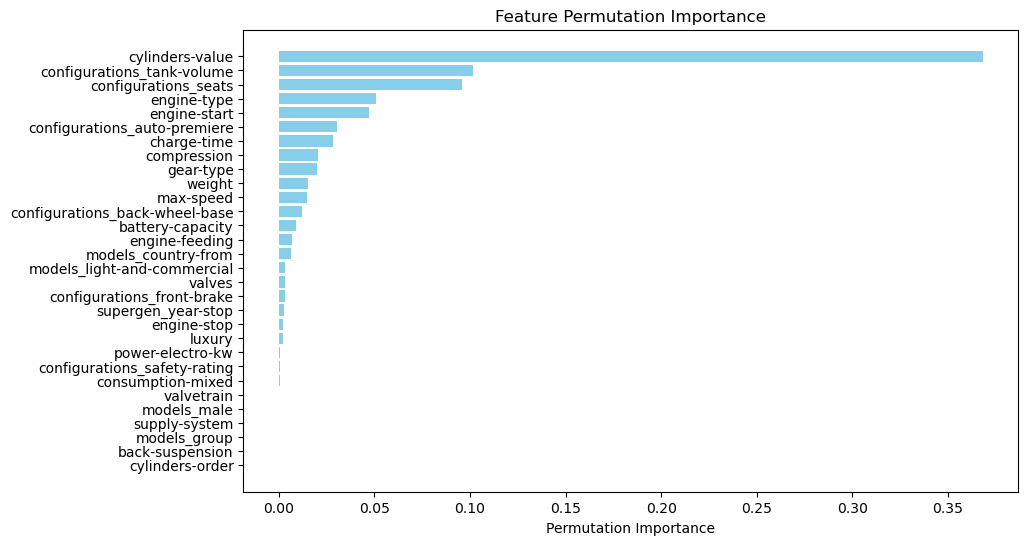

                           Feature  Importance
5                  cylinders-order   -0.000181
0                  back-suspension   -0.000001
27                    models_group    0.000005
15                   supply-system    0.000078
29                     models_male    0.000154
17                      valvetrain    0.000256
4                consumption-mixed    0.000529
22    configurations_safety-rating    0.000650
14                power-electro-kw    0.000761
12                          luxury    0.001981
9                      engine-stop    0.002145
25              supergen_year-stop    0.002633
21      configurations_front-brake    0.003109
16                          valves    0.003112
28     models_light-and-commercial    0.003288
26             models_country-from    0.006330
7                   engine-feeding    0.006988
1                 battery-capacity    0.008929
20  configurations_back-wheel-base    0.011889
13                       max-speed    0.014456
18           

In [9]:
#гистограмма
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Permutation Importance")
plt.title("Feature Permutation Importance")
plt.show()

print(importance_df)

<div class="alert alert-block alert-info"> Вывод по полученным результатам

Можно заметить, что самой значимой переменной оказалась cylinders-value, ее показатель важности более, чем в 3 раза превысил показатель важности стоящего далее признака (configurations_tank-volume со значением 0.103463). Третье по важности место занял показатель  configurations_seats.

Стоит отметить, что результаты данного цикла полностью совпали с результатами функции PermutationImportance, что говорит о хороших результатах выполнения работы.